In [3]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from category_encoders.target_encoder import TargetEncoder
import interpolation

In [4]:
filled_1850 = pd.read_csv("../data/dwelling_filled_sum_1850_mn.csv")
census_1880 = pd.read_csv("../data/census_1880_mn_blocks.csv")
filled_1850.rename(columns = {"CENSUS_WARD_NUM":"WARD_NUM", "CENSUS_SERIALP":"CENSUS_SERIALB", "BLOCK_NUM":"block_num"}, inplace = True)

In [5]:
dwellings_1850, dwellings_1880, census_1850_model, census_1880_model = interpolation.sequence_datasets(filled_1850, census_1880)

What we want to think about is dwellings inbetween those that we've assigned addresses to through the linkage process. It stands to reason that when there's a limited number of dwellings (exact limit is something to explore) in between two dwellings on the same street for example, that it's likely those dwellings in between are also on the same street

In [32]:
def same_next(column, dwellings_df):
    dwellings_df = dwellings_df.copy()
    dwellings_df[str(column) + "_next"] = dwellings_df[column].shift(-1)
    dwellings_df = dwellings_df[dwellings_df[str(column) + "_next"] == dwellings_df[column]]
    dwellings_df["num_between_real"] = dwellings_df["num_between"] - 1
    dwellings_df = dwellings_df[dwellings_df["num_between_real"] != 0]
    return dwellings_df

#### Street Name

In [33]:
#for reference, the number of dwellings in between is generated by the col_for_seq function
#in interpolation.py
#something to note is that the number of dwellings in between includes the dwelling itself
#so 1 means that it's really two consecutive dwellings
dwellings_1850_streets = same_next("street_name", dwellings_1850)
dwellings_1850_streets.head()

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_y,dist,num_between,sequence_id,sequence_len,sequence_order,house_number,street_name,street_name_next,num_between_real
63,1.0,126.0,3780.0,51 Whitehall,-74.012281,40.702543,45.0,4610.0,411.0,5.0,...,40.703331,0.065161,2.0,129.0,6.0,2.0,51.0,Whitehall,Whitehall,1.0
134,1.0,248.0,711.0,16 Wall,-74.010958,40.707407,22.0,4610.0,768.0,6.0,...,40.707255,0.005106,6.0,253.0,15.0,9.0,16.0,Wall,Wall,5.0
137,1.0,262.0,711.0,10 Wall,-74.011126,40.707499,30.0,4610.0,782.0,4.0,...,40.707313,0.003606,2.0,270.0,12.0,2.0,10.0,Wall,Wall,1.0
139,1.0,265.0,716.0,35 Wall,-74.010104,40.706670,40.0,4610.0,785.0,3.0,...,40.706209,0.072769,6.0,270.0,12.0,9.0,35.0,Wall,Wall,5.0
142,1.0,275.0,676.0,139 Washington,-74.013697,40.709763,64.0,4610.0,795.0,11.0,...,40.709692,0.002510,2.0,277.0,6.0,2.0,139.0,Washington,Washington,1.0


Range of dwellings between records on the same street: 1.0 - 18.0


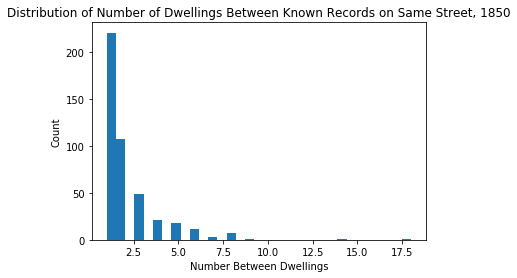

In [34]:
print("Range of dwellings between records on the same street:", min(dwellings_1850_streets.num_between_real), "-", max(dwellings_1850_streets.num_between_real))
plt.hist(dwellings_1850_streets["num_between_real"], bins = "auto")
plt.title("Distribution of Number of Dwellings Between Known Records on Same Street, 1850")
plt.xlabel("Number Between Dwellings")
plt.ylabel("Count")
plt.show()

In [35]:
def limit_dwellings_between(df, limit):
    df.copy()
    return df[df["num_between_real"] <= limit].copy()

In [36]:
dwellings_1850_streets_5 = limit_dwellings_between(dwellings_1850_streets, 5)
total_dwellings = dwellings_1850_streets_5[["num_between_real"]].sum().values[0]
all_dwellings = filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"]).ngroups
print("Total Dwellings to Fill In:", total_dwellings)
print("Percentage filled in of all dwellings", total_dwellings/all_dwellings)

Total Dwellings to Fill In: 758.0
Percentage filled in of all dwellings 0.03823455233291299


In [37]:
dwellings_1850_streets_10 = limit_dwellings_between(dwellings_1850_streets, 10)
total_dwellings = dwellings_1850_streets_10[["num_between_real"]].sum().values[0]
print("Total Dwellings to Fill In:", total_dwellings)
print("Percentage filled in of all dwellings", total_dwellings/all_dwellings)

Total Dwellings to Fill In: 916.0
Percentage filled in of all dwellings 0.04620428751576293


#### Block Number

In [38]:
dwellings_1850_block = same_next("block_num", dwellings_1850)
dwellings_1850_block.head()

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_y,dist,num_between,sequence_id,sequence_len,sequence_order,house_number,street_name,block_num_next,num_between_real
121,1.0,227.0,649.0,34 More,-74.013324,40.702469,28.0,4610.0,747.0,6.0,...,40.703419,0.070509,2.0,229.0,4.0,2.0,34.0,More,649.0,1.0
142,1.0,275.0,676.0,139 Washington,-74.013697,40.709763,64.0,4610.0,795.0,11.0,...,40.709692,0.002510,2.0,277.0,6.0,2.0,139.0,Washington,676.0,1.0
221,1.0,399.0,7.0,36 Trinity pl,-74.012578,40.708230,27.0,4610.0,923.0,9.0,...,40.708114,0.006054,3.0,402.0,6.0,4.0,36.0,Trinity pl,7.0,2.0
264,1.0,509.0,663.0,53 Greenwich,-74.014007,40.706665,35.0,4610.0,1765.0,7.0,...,40.706451,0.007090,3.0,517.0,10.0,3.0,53.0,Greenwich,663.0,2.0
267,1.0,514.0,663.0,45 Greenwich,-74.014120,40.706385,45.0,4610.0,1778.0,12.0,...,40.706809,0.014471,3.0,517.0,10.0,8.0,45.0,Greenwich,663.0,2.0


Range of dwellings between records on the same block: 1.0 - 18.0


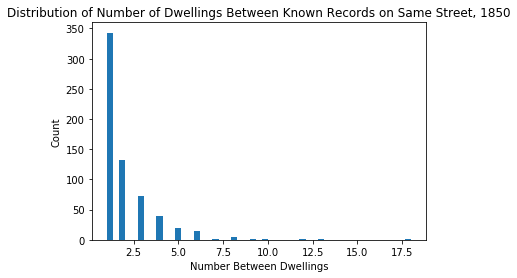

In [39]:
print("Range of dwellings between records on the same block:", min(dwellings_1850_block.num_between_real), "-", max(dwellings_1850_block.num_between_real))
plt.hist(dwellings_1850_block["num_between_real"], bins = "auto")
plt.title("Distribution of Number of Dwellings Between Known Records on Same Street, 1850")
plt.xlabel("Number Between Dwellings")
plt.ylabel("Count")
plt.show()

In [40]:
dwellings_1850_block_5 = limit_dwellings_between(dwellings_1850_block, 5)
total_dwellings = dwellings_1850_block_5[["num_between_real"]].sum().values[0]
print("Total Dwellings to Fill In:", total_dwellings)
print("Percentage filled in of all dwellings", total_dwellings/all_dwellings)

Total Dwellings to Fill In: 1076.0
Percentage filled in of all dwellings 0.05427490542244641


In [41]:
dwellings_1850_block_10 = limit_dwellings_between(dwellings_1850_block, 10)
total_dwellings = dwellings_1850_block_10[["num_between_real"]].sum().values[0]
print("Total Dwellings to Fill In:", total_dwellings)
print("Percentage filled in of all dwellings", total_dwellings/all_dwellings)

Total Dwellings to Fill In: 1250.0
Percentage filled in of all dwellings 0.06305170239596469


In [42]:
def get_consecutive_dwellings(all_dwellings, known_dwellings, column):
    known_dwellings["Known"] = 1
    prediction_data = interpolation.dwellings_to_all(all_dwellings, known_dwellings, list(set(list(known_dwellings.columns)).difference(list(all_dwellings.columns))) + ["WARD_NUM", "CENSUS_DWELLING_NUM"], ["WARD_NUM", "CENSUS_DWELLING_NUM"])
    interpolation.create_street_house(prediction_data, "CD_ADDRESS")
    
    next_col = str(column) + "_next" 
    dataframes = []
    find = None
    for row in prediction_data.itertuples():
        if row.Known == 1:
            index_start = row.Index
            find = getattr(row, next_col)

        elif find is not None and find == getattr(row, column):
            index_end = row.Index + 1
            dataframes.append(prediction_data.iloc[index_start:index_end])
            find = None

    return pd.concat(dataframes)

In [43]:
all_dwellings = filled_1850.groupby(["WARD_NUM", "CENSUS_DWELLING_NUM"], as_index = False).first()
predict_street = get_consecutive_dwellings(all_dwellings, dwellings_1850_streets_5, "street_name")

In [44]:
predict_street.head(30)

,WARD_NUM,CENSUS_DWELLING_NUM,block_num,CD_ADDRESS,CD_X,CD_Y,CENSUS_AGE,CENSUS_CITY,CENSUS_DWELLING_SEQ,CENSUS_DWELLING_SIZE,...,next_dnl,sequence_len,dwelling_num_listed,dist,house_number,next_x,Known,street_name_next,num_between_real,street_name
125,1,126.0,3780.0,51 Whitehall,-74.012281,40.702543,45,4610,411.0,5,...,127.0,6.0,125.0,0.065161,51.0,-74.013199,1.0,Whitehall,1.0,Whitehall
126,1,127.0,NaN,NaN,NaN,NaN,24,4610,413.0,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
127,1,128.0,649.0,26 Whitehall,-74.013199,40.703331,34,4610,414.0,7,...,NaN,NaN,NaN,NaN,26.0,NaN,NaN,NaN,NaN,Whitehall
247,1,248.0,711.0,16 Wall,-74.010958,40.707407,22,4610,768.0,6,...,253.0,15.0,247.0,0.005106,16.0,-74.011019,1.0,Wall,5.0,Wall
248,1,249.0,NaN,NaN,NaN,NaN,28,4610,769.0,10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
249,1,250.0,NaN,NaN,NaN,NaN,46,4610,770.0,7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
250,1,251.0,NaN,NaN,NaN,NaN,38,4610,771.0,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
251,1,252.0,NaN,NaN,NaN,NaN,36,4610,772.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
252,1,253.0,NaN,NaN,NaN,NaN,40,4610,773.0,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None
253,1,254.0,708.0,15 Wall,-74.011019,40.707255,32,4610,774.0,2,...,NaN,NaN,NaN,NaN,15.0,NaN,NaN,NaN,NaN,Wall


In [45]:
predict_block = get_consecutive_dwellings(all_dwellings, dwellings_1850_block_5, "block_num")

In [46]:
predict_block[["block_num", "block_num_next"]].head(10)

,block_num,block_num_next
226,649.0,649.0
227,NaN,NaN
228,649.0,NaN
274,676.0,676.0
275,NaN,NaN
276,676.0,NaN
398,7.0,7.0
399,NaN,NaN
400,NaN,NaN
401,7.0,NaN
